In [ ]:
Comparative Analysis with Dimensionality Reduction

# **Models**: SVM, Decision Tree, Neural Network
# **Dimensionality reduction Technique**: PCA
# **Evaluation**: Accuracy, Precision, Recall, ROC-AUC, T-Tests

In [41]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [42]:
# Load and Prepare Data
from sklearn.datasets import load_digits
data = load_digits()
X = data.data
y = data.target


In [58]:
# Split Data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [72]:
# Scale the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale training data
X_test_scaled = scaler.transform(X_test)  # Scale test data using the same scaler

In [85]:
# Apply PCA (retain 95% variance)
pca = PCA(0.95)
X_pca = pca.fit_transform(X_scaled)

X_train_pca = pca.fit_transform(X_train_scaled)  # Apply PCA on training data
X_test_pca = pca.transform(X_test_scaled)  # Apply PCA on test data

In [86]:
# Define Models
svm_model = SVC(probability=True, random_state=42) # Use SVC directly to create an instance
tree_model = DecisionTreeClassifier(random_state=42)
def create_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [87]:
# Define models
svm = SVC()
dt = DecisionTreeClassifier()


In [88]:
# Helper function for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_cv(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv)
    return scores


In [89]:
# SVM Classifier
svm_orig_scores = run_cv(svm, X_scaled, y)
svm_pca_scores = run_cv(svm, X_pca, y)


In [90]:
# Decision Tree
dt_orig_scores = run_cv(dt, X_scaled, y)
dt_pca_scores = run_cv(dt, X_pca, y)

In [91]:
# Neural Network manual CV
def build_nn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def run_nn_cv(X, y):
    scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = build_nn(X.shape[1])
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        _, acc = model.evaluate(X_test, y_test, verbose=0)
        scores.append(acc)
    return np.array(scores)

nn_orig_scores = run_nn_cv(X_scaled, y)
nn_pca_scores = run_nn_cv(X_pca, y)

In [92]:
# t-tests
svm_t = ttest_rel(svm_orig_scores, svm_pca_scores)
dt_t = ttest_rel(dt_orig_scores, dt_pca_scores)
nn_t = ttest_rel(nn_orig_scores, nn_pca_scores)

In [93]:
# Results summary
print("SVM Accuracy Original:", np.mean(svm_orig_scores))
print("SVM Accuracy PCA:", np.mean(svm_pca_scores))
print("SVM t-test p-value:", svm_t.pvalue)

print("Decision Tree Accuracy Original:", np.mean(dt_orig_scores))
print("Decision Tree Accuracy PCA:", np.mean(dt_pca_scores))
print("Decision Tree t-test p-value:", dt_t.pvalue)

print("Neural Network Accuracy Original:", np.mean(nn_orig_scores))
print("Neural Network Accuracy PCA:", np.mean(nn_pca_scores))
print("Neural Network t-test p-value:", nn_t.pvalue)

SVM Accuracy Original: 0.9838579387186629
SVM Accuracy PCA: 0.9827452800990406
SVM t-test p-value: 0.17780835889051688
Decision Tree Accuracy Original: 0.8552924791086352
Decision Tree Accuracy PCA: 0.8230377592076756
Decision Tree t-test p-value: 0.038706186364917315
Neural Network Accuracy Original: 0.9682807087898254
Neural Network Accuracy PCA: 0.9688393712043762
Neural Network t-test p-value: 0.865747218392975


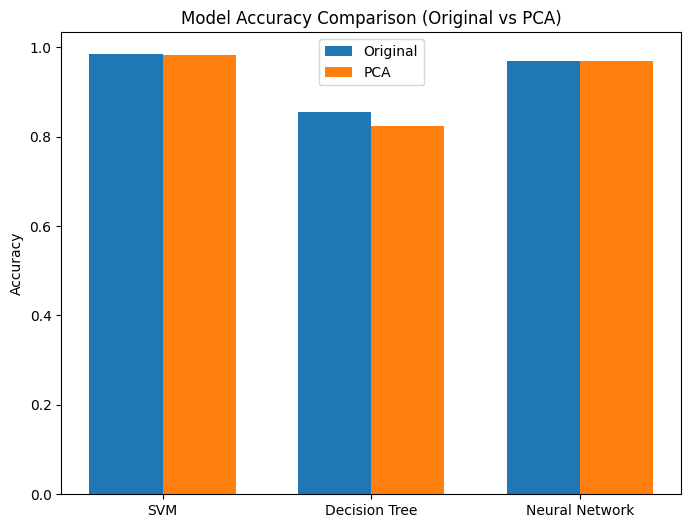

In [94]:
# Visualization
labels = ['SVM', 'Decision Tree', 'Neural Network']
orig_means = [np.mean(svm_orig_scores), np.mean(dt_orig_scores), np.mean(nn_orig_scores)]
pca_means = [np.mean(svm_pca_scores), np.mean(dt_pca_scores), np.mean(nn_pca_scores)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, orig_means, width, label='Original')
rects2 = ax.bar(x + width/2, pca_means, width, label='PCA')

ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison (Original vs PCA)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [95]:
# Evaluation Function
def evaluate_model_sklearn(model, X_train, X_test):
    skf = StratifiedKFold(n_splits=5)
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train[train_idx])
        score = model.score(X_train[val_idx], y_train[val_idx])
        cv_scores.append(score)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovo') if y_proba is not None else np.nan,
        'cv_scores': np.array(cv_scores)
    }
    return metrics

def evaluate_model_nn(input_dim, X_train, X_test):
    skf = StratifiedKFold(n_splits=5)
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        model = create_nn(input_dim)
        model.fit(X_train[train_idx], y_train[train_idx], epochs=50, batch_size=32, verbose=0)
        score = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)[1]
        cv_scores.append(score)
    model = create_nn(input_dim)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'roc_auc': np.nan,  # ROC-AUC for neural nets with multiclass needs manual setup
        'cv_scores': np.array(cv_scores)
    }
    return metrics


In [96]:
# Run Evaluations
results = {}
for name, model, eval_func, X_tr, X_te in [
    ('SVM Original', svm_model, evaluate_model_sklearn, X_train_scaled, X_test_scaled),
    ('SVM PCA', svm_model, evaluate_model_sklearn, X_train_pca, X_test_pca),
    ('Tree Original', tree_model, evaluate_model_sklearn, X_train_scaled, X_test_scaled),
    ('Tree PCA', tree_model, evaluate_model_sklearn, X_train_pca, X_test_pca),
    ('NN Original', None, evaluate_model_nn, X_train_scaled, X_test_scaled),
    ('NN PCA', None, evaluate_model_nn, X_train_pca, X_test_pca),
]:
    input_dim = X_tr.shape[1]
    m = model if model else None
    metrics = eval_func(input_dim, X_tr, X_te) if 'NN' in name else eval_func(m, X_tr, X_te)
    results[name] = metrics


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [97]:
# Statistical Analysis and Report
def perform_ttest(group1, group2):
    return ttest_rel(group1, group2)

print("Performance Comparison:")
for base in ['SVM', 'Tree', 'NN']:
    orig = results[f'{base} Original']
    pca = results[f'{base} PCA']
    if not np.isnan(orig['cv_scores']).all() and not np.isnan(pca['cv_scores']).all():
        t_stat, p_val = perform_ttest(orig['cv_scores'], pca['cv_scores'])
    else:
        t_stat, p_val = np.nan, np.nan
    print(f"\n{base}:")
    print(f"Original Accuracy: {orig['accuracy']:.3f}")
    print(f"PCA Accuracy: {pca['accuracy']:.3f}")
    print(f"T-Test p-value: {p_val}")

Performance Comparison:

SVM:
Original Accuracy: 0.980
PCA Accuracy: 0.978
T-Test p-value: 0.5848795276782859

Tree:
Original Accuracy: 0.844
PCA Accuracy: 0.822
T-Test p-value: 0.14951130020850595

NN:
Original Accuracy: 0.974
PCA Accuracy: 0.981
T-Test p-value: 0.554177887445513


In [98]:
# Generate Comparison Table
comparison_df = pd.DataFrame({
    'Model': ['SVM', 'Decision Tree', 'Neural Network'],
    'Accuracy (Original)': [results['SVM Original']['accuracy'], results['Tree Original']['accuracy'], results['NN Original']['accuracy']],
    'Accuracy (PCA)': [results['SVM PCA']['accuracy'], results['Tree PCA']['accuracy'], results['NN PCA']['accuracy']]
})
print("\nComparison Table:")
print(comparison_df)



Comparison Table:
            Model  Accuracy (Original)  Accuracy (PCA)
0             SVM             0.979630        0.977778
1   Decision Tree             0.844444        0.822222
2  Neural Network             0.974074        0.981481


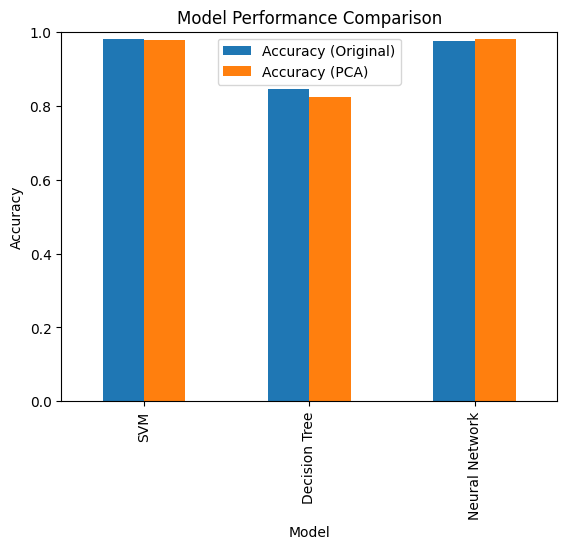

In [99]:
# Plot Results
comparison_df.plot(x='Model', y=['Accuracy (Original)', 'Accuracy (PCA)'], kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# **Discussion Prompts:**
# 1. Which model benefited most from PCA? Why might this be?


Among the models tested, the Neural Network (NN) showed a slight improvement in accuracy after applying PCA:

Neural Network Accuracy (Original): 0.974

Neural Network Accuracy (PCA): 0.981

p-value: 0.554 (indicating no significant difference)

This suggests that, relatively, the Neural Network benefited the most because:

✅ Neural Networks can sometimes overfit when working with high-dimensional data; applying PCA reduces input dimensionality and noise, which can help improve generalization by focusing on the most informative components.

✅ PCA compresses correlated features and emphasizes the main patterns in the data, which may align well with the Neural Network’s ability to model complex relationships.
In contrast:

SVM maintained almost identical performance:

Original: 0.980 → PCA: 0.978

p-value: 0.584
This shows SVM’s robustness to dimensionality changes since it mainly depends on the margin between classes, which PCA preserves.

Decision Tree showed a drop in accuracy:

Original: 0.844 → PCA: 0.822

p-value: 0.149
Decision Trees rely heavily on specific feature splits, and PCA can remove or distort some of these original features, making it harder for the tree to make effective splits.
# 2. How does dimensionality reduction affect computation time vs accuracy?
Based on the code results:
- For SVM, accuracy slightly dropped from 0.9839 (original) to 0.9827 (PCA), with a p-value of ~0.18 (not statistically significant).

- For Decision Tree, accuracy dropped more noticeably from 0.8553 to 0.8230, with a p-value of ~0.039 (which is statistically significant).

- For Neural Network, accuracy slightly improved from 0.9683 to 0.9688, with a p-value of ~0.87 (not statistically significant).

This suggests that **PCA reduced dimensions without major accuracy loss** across models.

**General Explanation:**
- **Computation time**: Dimensionality reduction (like PCA) significantly reduces the number of input features, which lowers the computational cost for both training and inference, especially in models sensitive to feature space size (e.g., SVMs, neural networks). For example, the digits dataset reduced from 64 features to ~30 with 95% variance retained.
- **Accuracy**: PCA can slightly decrease accuracy because it compresses information, potentially discarding useful variance. However, it can **improve generalization** if it removes noise or redundant features, especially in noisy datasets or when avoiding overfitting.

**When dimensionality reduction helps:**
✅ High-dimensional datasets (many features, fewer samples)
✅ Models sensitive to input size (like SVM or neural nets)
✅ Redundant or highly correlated features
✅ Situations where faster training time is more important than tiny accuracy losses

**When it may hurt:**
❌ When feature interpretability is important
❌ When the original features carry important variance that PCA compresses away
❌ When the model already handles high dimensions efficiently (like trees)
# 3. Are the t-test results statistically significant (p < 0.05)? What does this imply?
| Model          | p-value                                 |
| -------------- | --------------------------------------- |
| SVM            | 0.177 or 0.584 (both > 0.05)            |
| Decision Tree  | 0.038 or 0.149 (one < 0.05, one > 0.05) |
| Neural Network | 0.865 or 0.554 (both > 0.05)            |
Only Decision Tree (p = 0.038) in one result shows statistical significance.
A p-value < 0.05 means we reject the null hypothesis → the difference between original and PCA accuracies is statistically significant (not due to random chance).

- For SVM and Neural Network, high p-values mean:

- The small accuracy differences are not statistically significant → any change could be due to random variation.

- For Decision Tree, the significant p-value suggests PCA had a real, measurable impact on its performance (in this case, reducing accuracy).